In [1]:
%run /Users/denis/Documents/Projects/scripts/init.ipy
os.chdir(os.getcwd().replace('/pipeline/notebooks', ''));

In [2]:
infiles = ('./s1-normalized.dir/correlation.feather', './s1-normalized.dir/zscore.feather', './s1-normalized.dir/generif_overlap_zscore.feather', './s1-normalized.dir/autorif_overlap_zscore.feather')

In [3]:
matrix_genes = {os.path.basename(x)[:-len('.feather')]: set(pd.read_feather(x).set_index('gene_symbol').index) for x in infiles}

/Users/denis/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead



In [234]:
def readGMT(infile):
    gmt = {}
    with open(infile) as openfile:
        for line in openfile.read().split('\n'):
            split_line = line.strip().split('\t')
            if split_line[0]:
                gmt[split_line[0]] = [x.split(',')[0] for x in split_line[2:]]
    return gmt


In [235]:
# Read GMT
libraries = {os.path.basename(x)[:-len('.txt')]: readGMT(x) for x in glob.glob('libraries.dir/*.txt')}

In [6]:
from matplotlib_venn import venn3

In [7]:
list(matrix_genes.keys())

['correlation', 'zscore', 'generif_overlap_zscore', 'autorif_overlap_zscore']

## 1. Overlap across similiarity matrices

In [185]:
matrix_counts = pd.Series({key: len(value) for key, value in matrix_genes.items()}).rename('genes').to_frame()
matrix_counts

genes
correlation             16915
zscore                  23568
generif_overlap_zscore  11433
autorif_overlap_zscore  11086

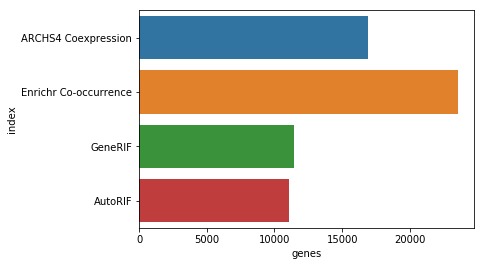

In [186]:
sns.barplot('genes', 'index', data=matrix_counts.reset_index().replace('correlation', 'ARCHS4 Coexpression').replace('generif_overlap_zscore', 'GeneRIF').replace('autorif_overlap_zscore', 'AutoRIF').replace('zscore', 'Enrichr Co-occurrence'));

In [187]:
matrix_counts = matrix_counts.reset_index().replace('correlation', 'ARCHS4 Coexpression').replace('generif_overlap_zscore', 'GeneRIF').replace('autorif_overlap_zscore', 'AutoRIF').replace('zscore', 'Enrichr Co-occurrence')
matrix_counts.head()

index  genes
0    ARCHS4 Coexpression  16915
1  Enrichr Co-occurrence  23568
2                GeneRIF  11433
3                AutoRIF  11086

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



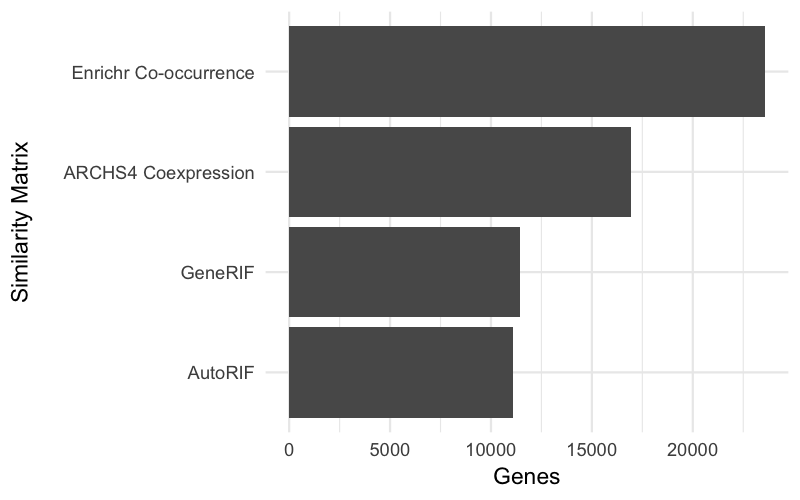

In [219]:
%%R -i matrix_counts -h 500 -w 800 -r 150
ggplot(matrix_counts, aes(x=reorder(index, genes), y=genes)) +
geom_bar(stat='identity') +
coord_flip() +
#facet_wrap(~) +
#scale_fill_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_x_continuous(lim=c(,), breaks=ticks, labels=ticks) +
#scale_y_continuous(lim=c(,), breaks=ticks, labels=ticks) +
#ggtitle('') +
xlab('Similarity Matrix\n') +
ylab('Genes') +
theme_minimal()

In [8]:
from itertools import combinations

In [9]:
[x for x in combinations(matrix_genes.keys(), 3)]

[('correlation', 'zscore', 'generif_overlap_zscore'),
 ('correlation', 'zscore', 'autorif_overlap_zscore'),
 ('correlation', 'generif_overlap_zscore', 'autorif_overlap_zscore'),
 ('zscore', 'generif_overlap_zscore', 'autorif_overlap_zscore')]

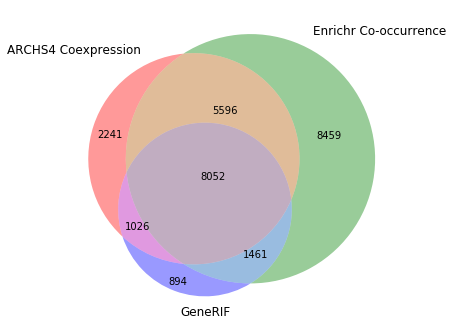

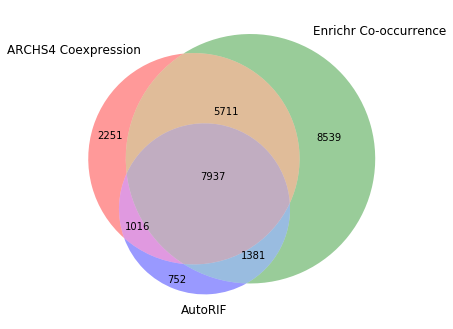

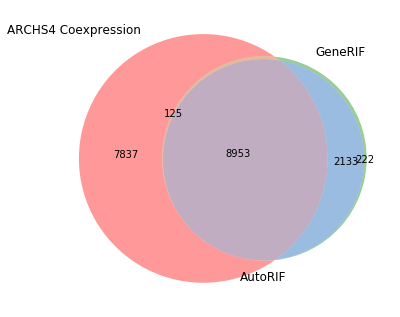

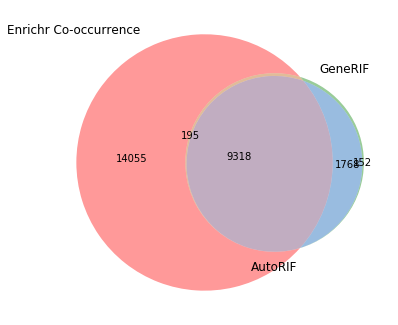

In [218]:
for gmts in combinations(matrix_genes.keys(), 3):
    plt.figure(figsize=(6,10));
    venn3([matrix_genes[x] for x in gmts], [x.replace('correlation', 'ARCHS4 Coexpression').replace('generif_overlap_zscore', 'GeneRIF').replace('autorif_overlap_zscore', 'AutoRIF').replace('zscore', 'Enrichr Co-occurrence') for x in gmts]);

## 2. Overlap across libraries

In [236]:
libraries_merged = {library_name: set([gene for term_genes in gmt.values() for gene in term_genes]) for library_name, gmt in libraries.items()}

In [237]:
counts = pd.Series({index: len(value) for index, value in libraries_merged.items()}).rename('genes').to_frame().rename_axis('library').reset_index()
counts.head()

library  genes
0  GO_Molecular_Function_2018  11459
1            ARCHS4_TFs_Coexp  25983
2                       huMAP   2243
3               Reactome_2016   8973
4           WikiPathways_2016   5966

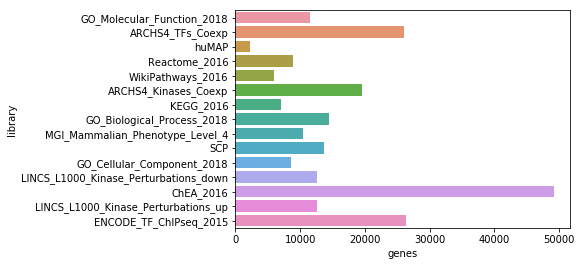

In [238]:
sns.barplot('genes', 'library', data=counts);

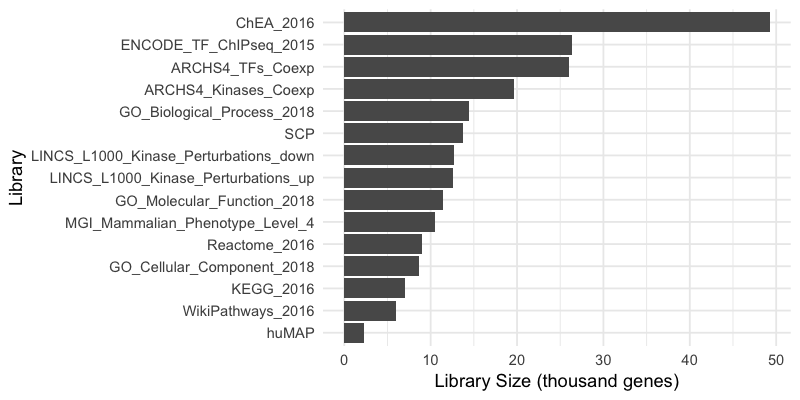

In [245]:
%%R -i counts -h 400 -w 800 -r 120
ggplot(counts, aes(x=reorder(library, genes), y=genes/1000)) +
geom_bar(stat='identity') +
coord_flip() +
#facet_wrap(~, scales='free') +
#scale_fill_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_x_log10() +
#scale_y_log10() +
#scale_x_continuous(lim=c(,), breaks=ticks, labels=ticks) +
#scale_y_continuous(lim=c(,), breaks=ticks, labels=ticks) +
#ggtitle('') +
xlab('Library') +
ylab('Library Size (thousand genes)') +
theme_minimal()

/Users/denis/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



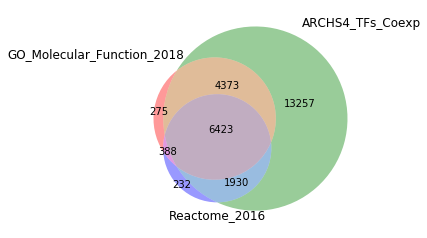

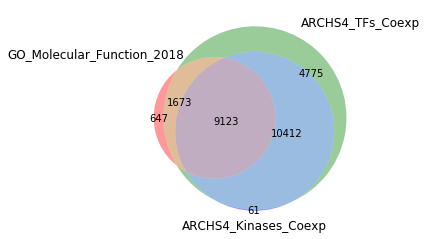

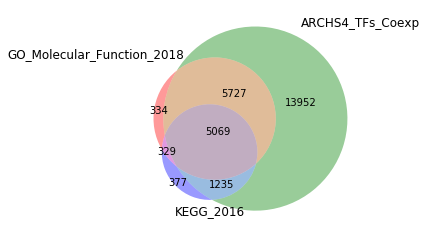

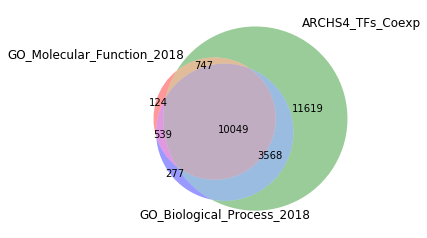

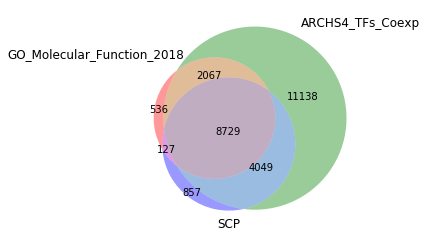

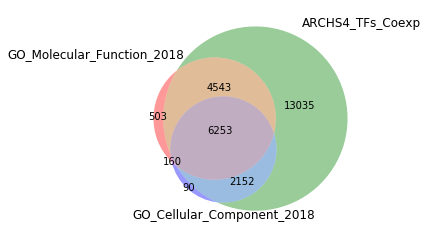

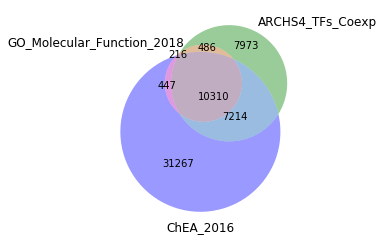

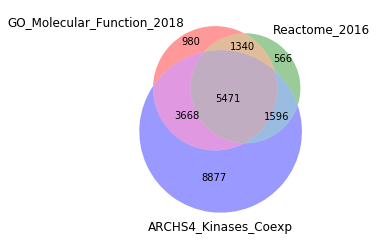

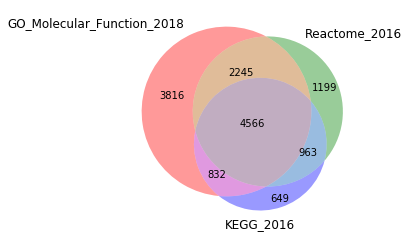

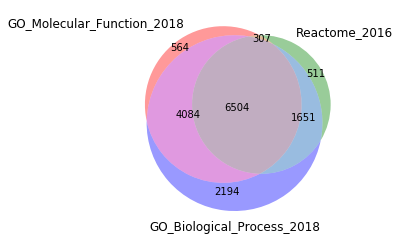

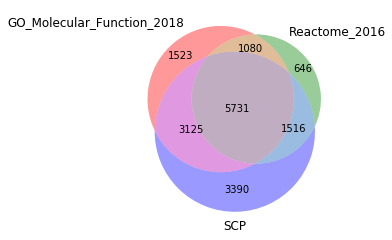

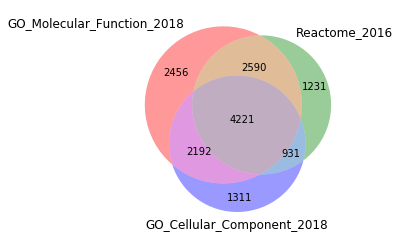

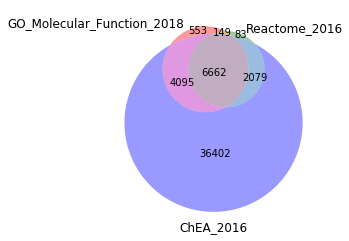

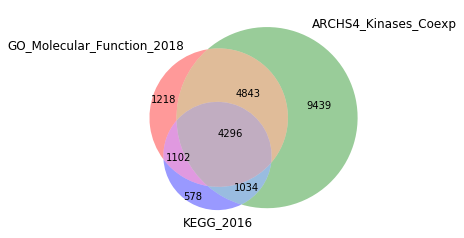

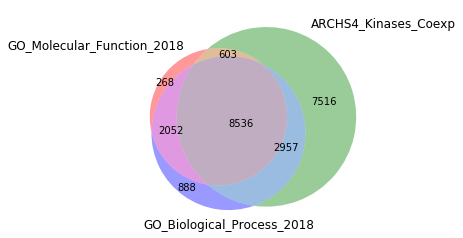

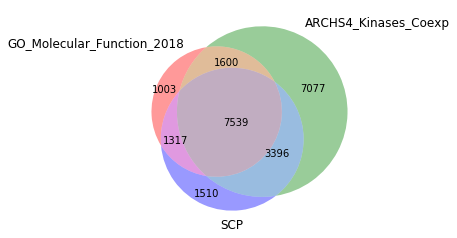

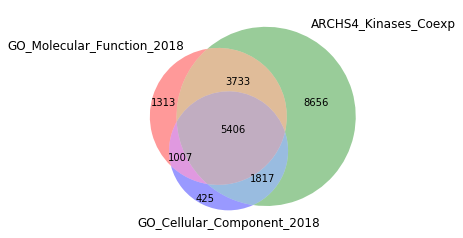

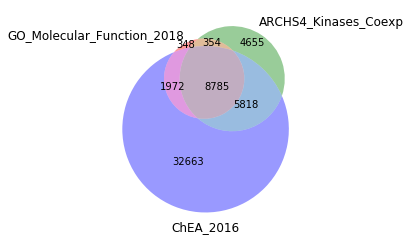

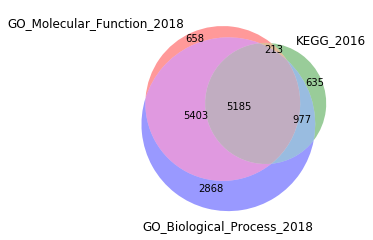

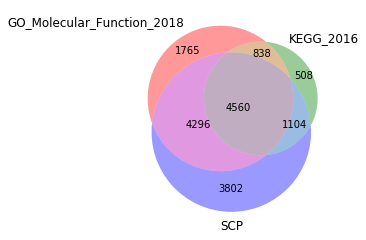

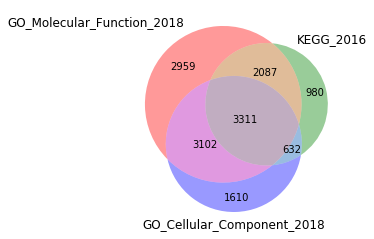

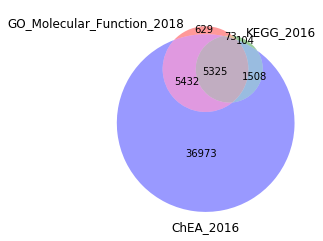

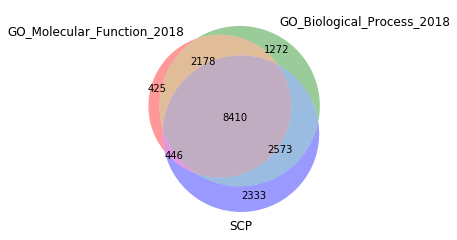

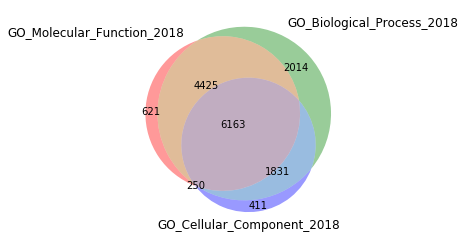

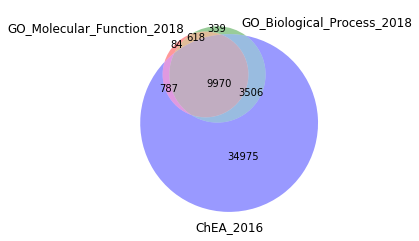

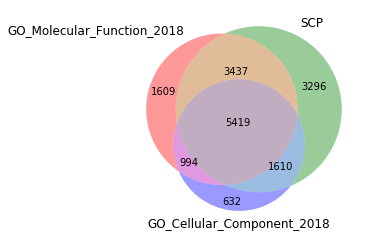

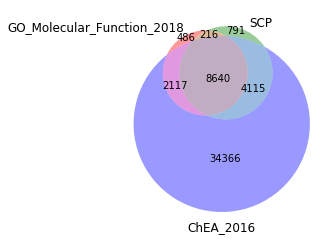

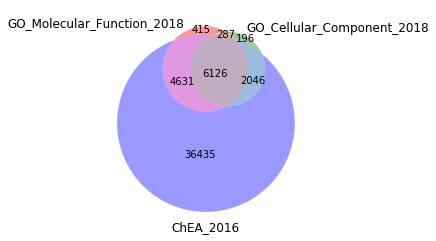

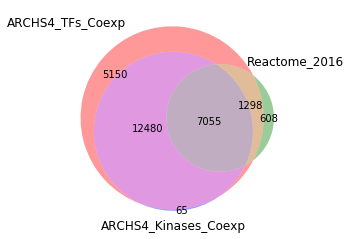

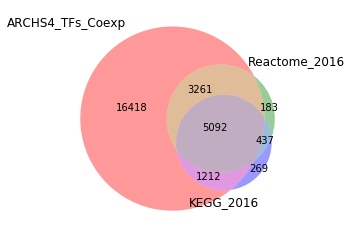

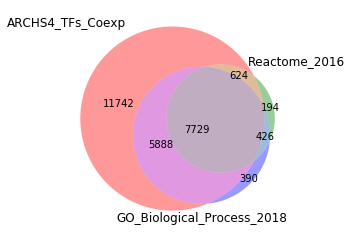

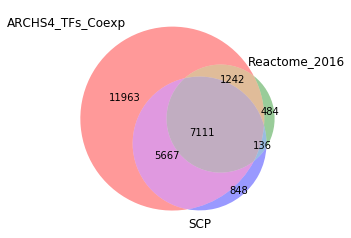

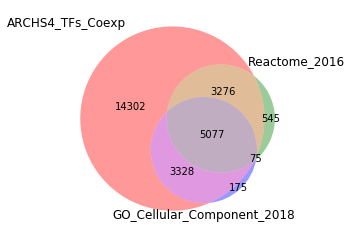

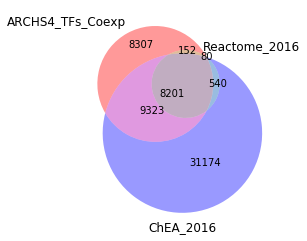

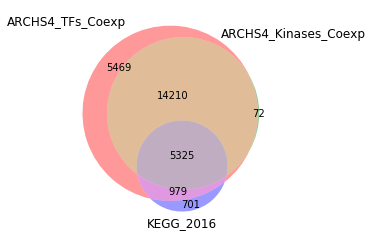

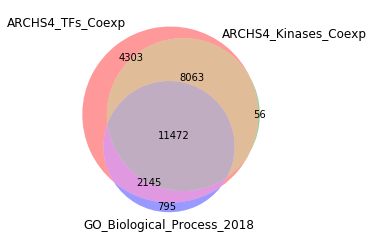

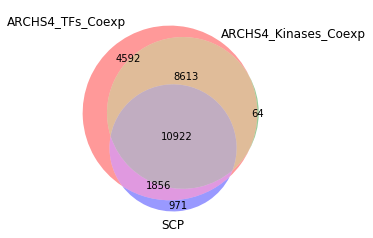

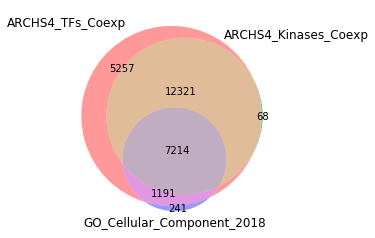

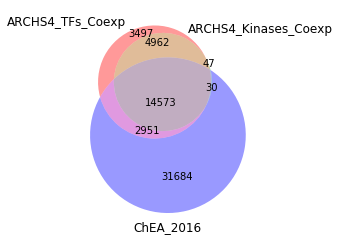

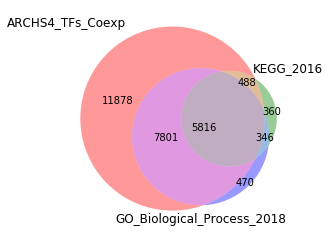

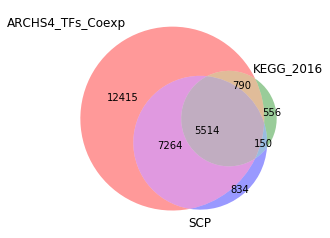

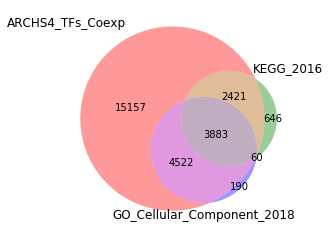

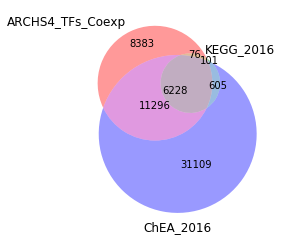

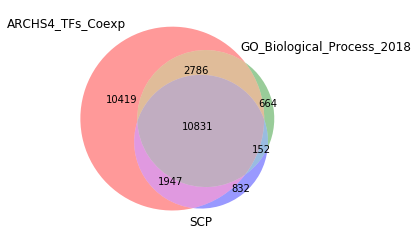

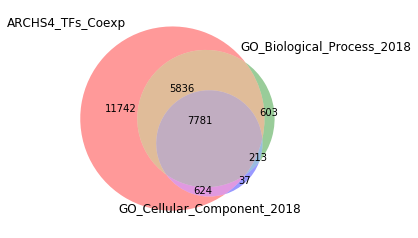

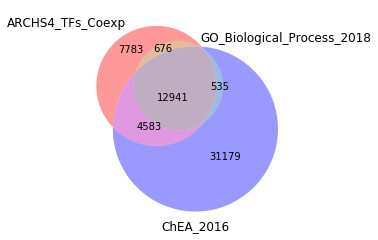

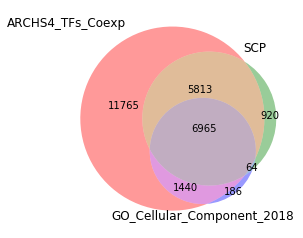

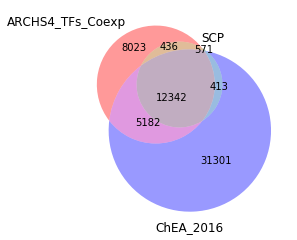

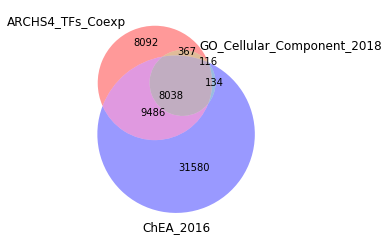

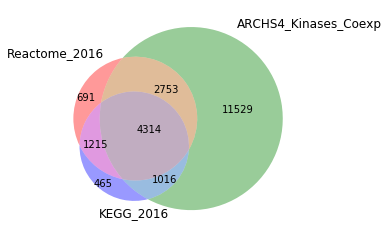

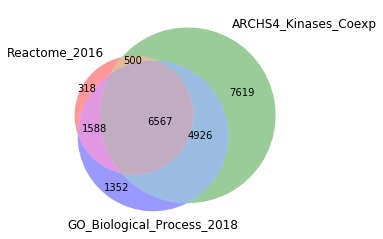

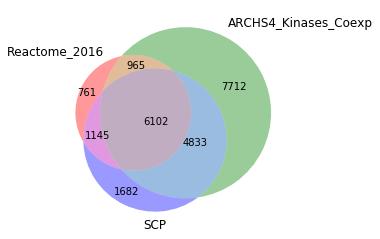

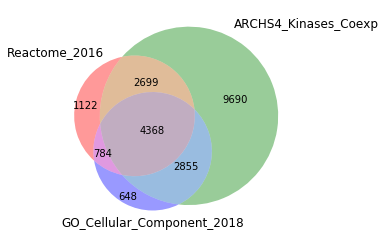

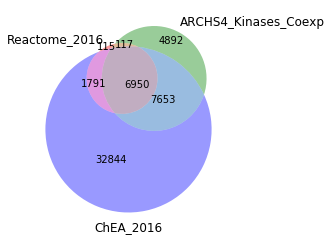

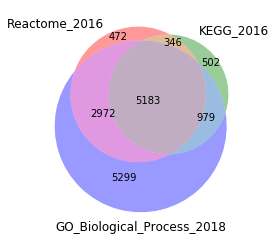

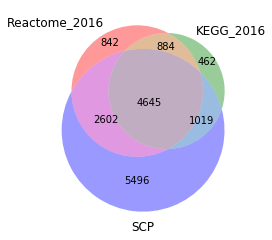

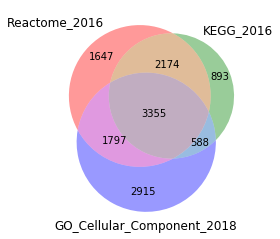

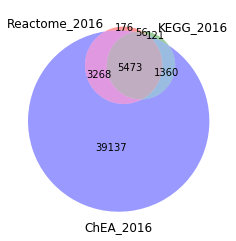

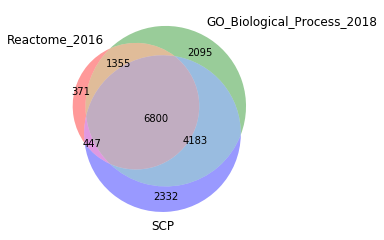

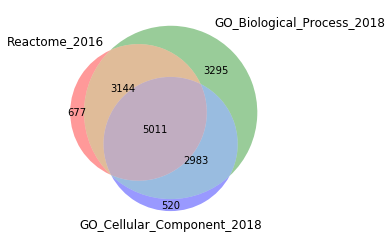

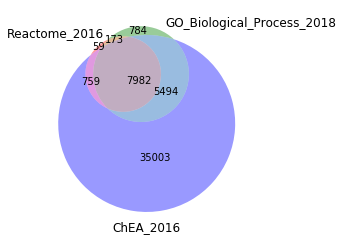

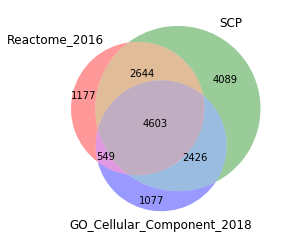

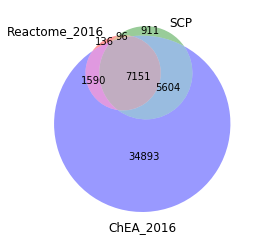

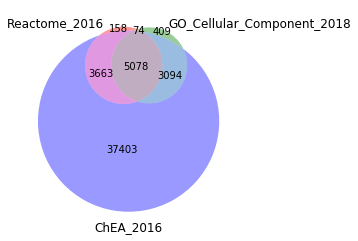

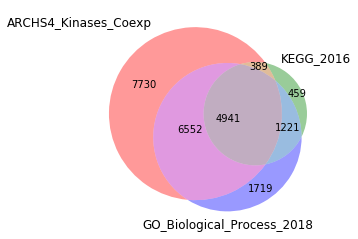

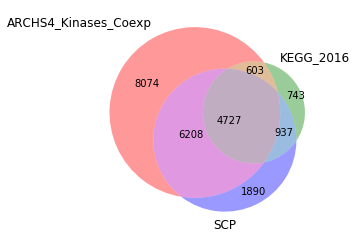

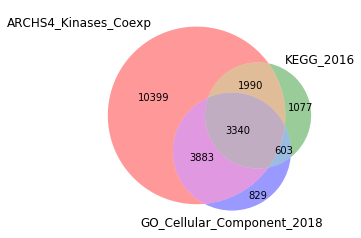

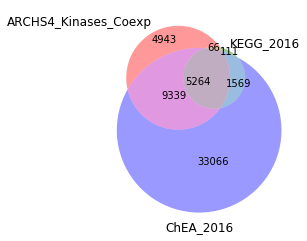

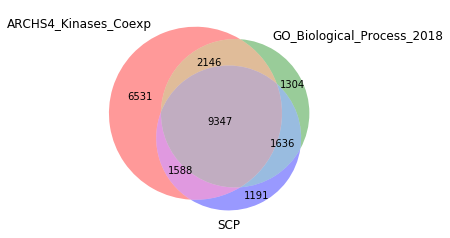

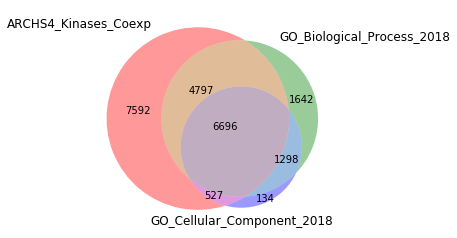

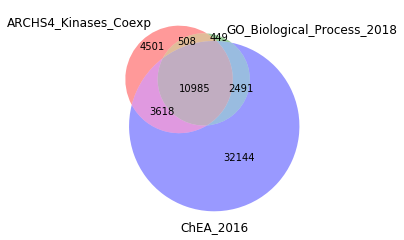

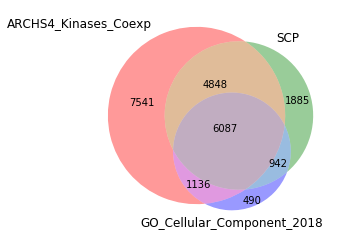

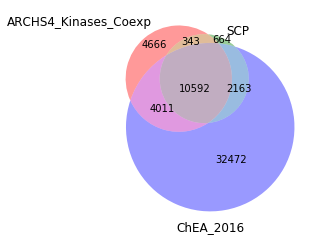

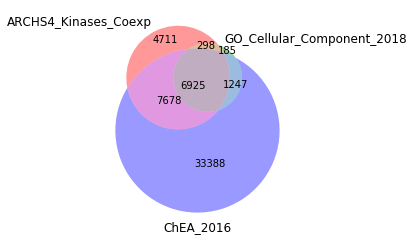

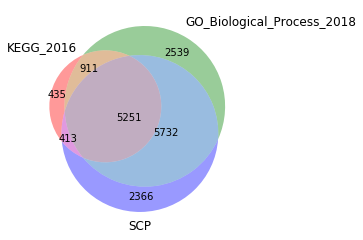

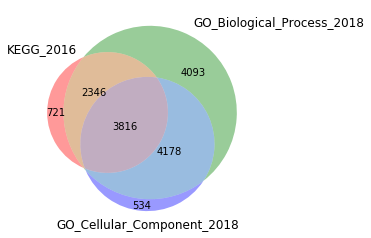

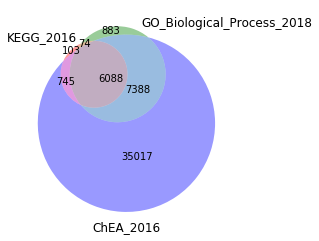

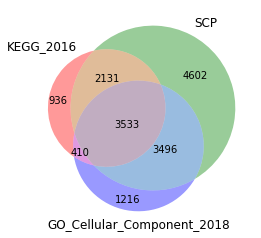

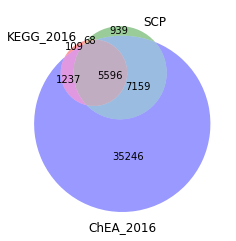

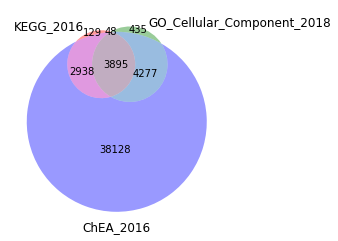

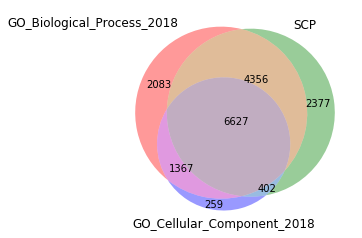

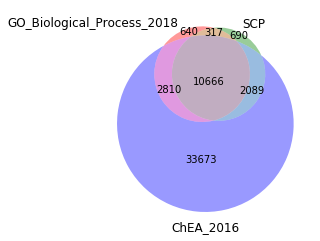

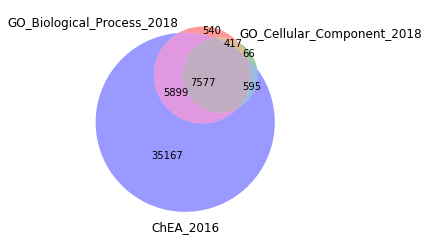

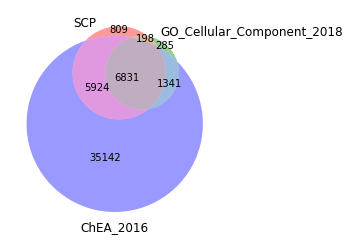

In [16]:
for gmts in combinations(libraries_merged.keys(), 3):
    plt.figure();
    venn3([libraries_merged[x] for x in gmts], gmts);

## 3. GMT Genes Represented

In [17]:
results = {x: {} for x in matrix_genes.keys()}
for matrix_name, matrix_set in matrix_genes.items():
    for library_name, library_set in libraries_merged.items():
        results[matrix_name][library_name] = len(matrix_set.intersection(library_set))

In [18]:
result_dataframe = pd.DataFrame(results)
result_dataframe.head()

correlation  zscore  generif_overlap_zscore  \
ARCHS4_Kinases_Coexp              14167   13666                    9006   
ARCHS4_TFs_Coexp                  16833   16611                   10529   
ChEA_2016                         14764   16371                   10791   
GO_Biological_Process_2018        11784   12247                    8981   
GO_Cellular_Component_2018         7579    7533                    5698   

                            autorif_overlap_zscore  
ARCHS4_Kinases_Coexp                          8875  
ARCHS4_TFs_Coexp                             10358  
ChEA_2016                                    10586  
GO_Biological_Process_2018                    8886  
GO_Cellular_Component_2018                    5648

In [34]:
gmt_represented

correlation  zscore  generif_overlap_zscore  \
ARCHS4_Kinases_Coexp              14167   13666                    9006   
ARCHS4_TFs_Coexp                  16833   16611                   10529   
ChEA_2016                         14764   16371                   10791   
GO_Biological_Process_2018        11784   12247                    8981   
GO_Cellular_Component_2018         7579    7533                    5698   
GO_Molecular_Function_2018         9353    9658                    7242   
KEGG_2016                          5489    5574                    4430   
Reactome_2016                      7345    7402                    5664   
SCP                               11092   11443                    8660   

                            autorif_overlap_zscore  
ARCHS4_Kinases_Coexp                          8875  
ARCHS4_TFs_Coexp                             10358  
ChEA_2016                                    10586  
GO_Biological_Process_2018                    8886  
GO_Cellular_Component_2018                    5648  
GO_Molecular_Function_2018                    7180  
KEGG_2016                                     4402  
Reactome_2016                                 5625  
SCP                                           8633

In [36]:
counts

library  genes
0  GO_Molecular_Function_2018  11459
1            ARCHS4_TFs_Coexp  25983
2               Reactome_2016   8973
3        ARCHS4_Kinases_Coexp  19612
4                   KEGG_2016   7010
5  GO_Biological_Process_2018  14433
6                         SCP  13762
7  GO_Cellular_Component_2018   8655
8                   ChEA_2016  49238

In [94]:
gmt_represented = result_dataframe.copy()
for library in gmt_represented.index:
    gmt_represented.loc[library] = gmt_represented.loc[library]/counts.set_index('library').loc[library].values[0]
gmt_represented.head()

correlation    zscore  generif_overlap_zscore  \
ARCHS4_Kinases_Coexp           0.722364  0.696818                0.459209   
ARCHS4_TFs_Coexp               0.647847  0.639303                0.405226   
ChEA_2016                      0.299850  0.332487                0.219160   
GO_Biological_Process_2018     0.816462  0.848542                0.622255   
GO_Cellular_Component_2018     0.875679  0.870364                0.658348   

                            autorif_overlap_zscore  
ARCHS4_Kinases_Coexp                      0.452529  
ARCHS4_TFs_Coexp                          0.398645  
ChEA_2016                                 0.214997  
GO_Biological_Process_2018                0.615672  
GO_Cellular_Component_2018                0.652571

In [95]:
gmt_represented_melt = pd.melt(gmt_represented.reset_index(), id_vars='index').replace('correlation', 'ARCHS4 Coexpression').replace('generif_overlap_zscore', 'GeneRIF').replace('autorif_overlap_zscore', 'AutoRIF').replace('zscore', 'Enrichr Co-occurrence')
gmt_represented_melt.head()

index             variable     value
0        ARCHS4_Kinases_Coexp  ARCHS4 Coexpression  0.722364
1            ARCHS4_TFs_Coexp  ARCHS4 Coexpression  0.647847
2                   ChEA_2016  ARCHS4 Coexpression  0.299850
3  GO_Biological_Process_2018  ARCHS4 Coexpression  0.816462
4  GO_Cellular_Component_2018  ARCHS4 Coexpression  0.875679

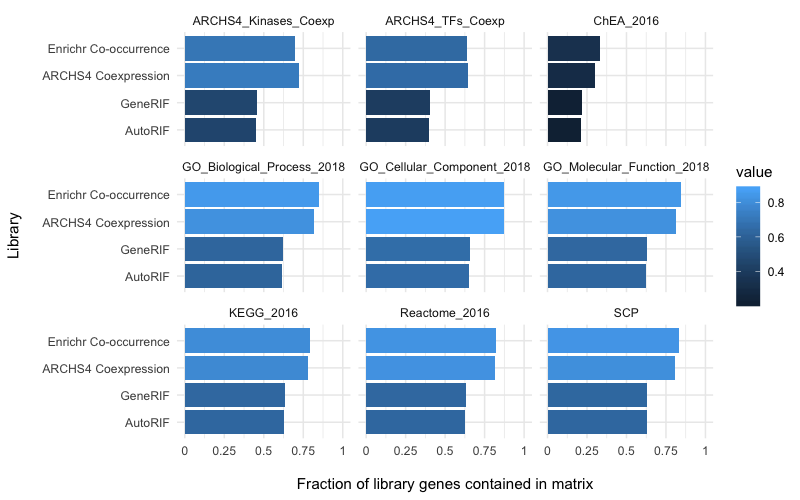

In [157]:
%%R -i gmt_represented_melt -h 500 -w 800 -r 100
ticks <- seq(0,1,0.25)
ggplot(gmt_represented_melt, aes(x=reorder(variable, value), y=value, fill=value)) +
geom_bar(stat='identity') +
facet_wrap(~index) +
coord_flip() +
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
scale_y_continuous(lim=c(0,1), breaks=ticks, labels=ticks) + 
# ggtitle('Fraction of library genes contained in similarity matrices') +
ylab('\nFraction of library genes contained in matrix') +
xlab('Library\n') +
theme_minimal() +
theme(plot.title = element_text(hjust = 0.5))

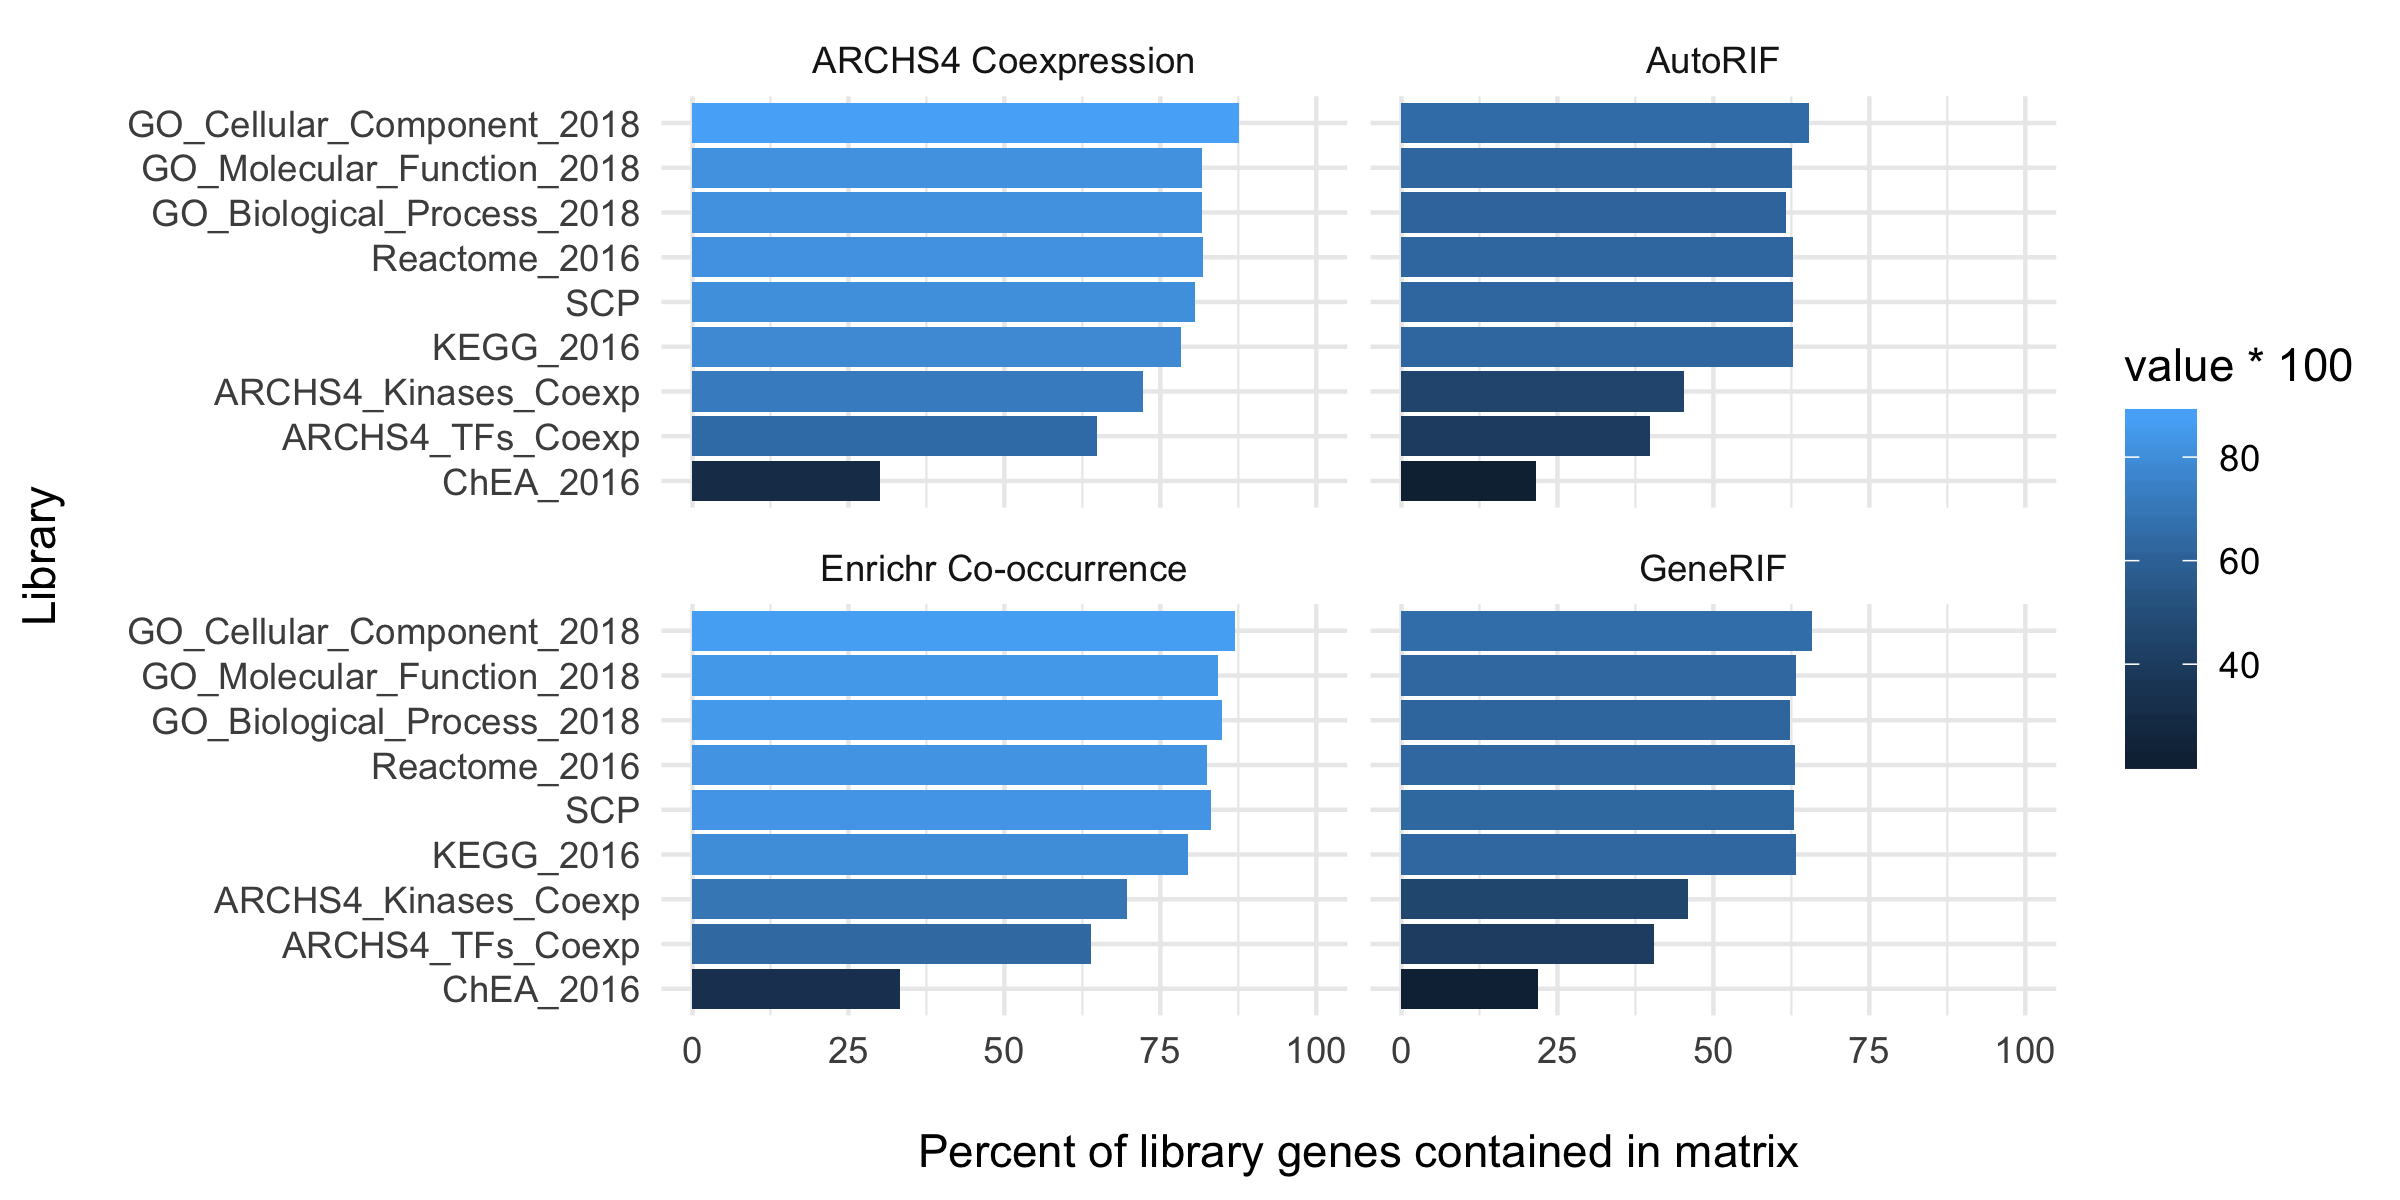

In [233]:
%%R -i gmt_represented_melt -h 1200 -w 2400 -r 300
ticks <- seq(0,100,25)
ggplot(gmt_represented_melt, aes(x=reorder(index, value), y=value*100, fill=value*100)) +
geom_bar(stat='identity') +
facet_wrap(~variable) +
coord_flip() +
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
scale_y_continuous(lim=c(0,100), breaks=ticks, labels=ticks) + 
# ggtitle('Fraction of library genes contained in similarity matrices') +
ylab('\nPercent of library genes contained in matrix') +
xlab('Library\n') +
theme_minimal() +
theme(plot.title = element_text(hjust = 0.5))

## 4. Library Genes Represented

In [103]:
result_dataframe.head()

correlation  zscore  generif_overlap_zscore  \
ARCHS4_Kinases_Coexp              14167   13666                    9006   
ARCHS4_TFs_Coexp                  16833   16611                   10529   
ChEA_2016                         14764   16371                   10791   
GO_Biological_Process_2018        11784   12247                    8981   
GO_Cellular_Component_2018         7579    7533                    5698   

                            autorif_overlap_zscore  
ARCHS4_Kinases_Coexp                          8875  
ARCHS4_TFs_Coexp                             10358  
ChEA_2016                                    10586  
GO_Biological_Process_2018                    8886  
GO_Cellular_Component_2018                    5648

In [104]:
matrix_counts

genes
correlation             16915
zscore                  23568
generif_overlap_zscore  11433
autorif_overlap_zscore  11086

In [106]:
library_represented = result_dataframe.copy()
for similarity in library_represented.columns:
    library_represented[similarity] = library_represented[similarity]/matrix_counts.loc[similarity].values[0]
library_represented.head()

correlation    zscore  generif_overlap_zscore  \
ARCHS4_Kinases_Coexp           0.837541  0.579854                0.787720   
ARCHS4_TFs_Coexp               0.995152  0.704812                0.920931   
ChEA_2016                      0.872835  0.694628                0.943847   
GO_Biological_Process_2018     0.696660  0.519645                0.785533   
GO_Cellular_Component_2018     0.448064  0.319628                0.498382   

                            autorif_overlap_zscore  
ARCHS4_Kinases_Coexp                      0.800559  
ARCHS4_TFs_Coexp                          0.934332  
ChEA_2016                                 0.954898  
GO_Biological_Process_2018                0.801552  
GO_Cellular_Component_2018                0.509471

In [107]:
library_represented_melt = pd.melt(library_represented.reset_index(), id_vars='index').replace('correlation', 'ARCHS4 Coexpression').replace('generif_overlap_zscore', 'GeneRIF').replace('autorif_overlap_zscore', 'AutoRIF').replace('zscore', 'Enrichr Co-occurrence')
library_represented_melt.head()

index             variable     value
0        ARCHS4_Kinases_Coexp  ARCHS4 Coexpression  0.837541
1            ARCHS4_TFs_Coexp  ARCHS4 Coexpression  0.995152
2                   ChEA_2016  ARCHS4 Coexpression  0.872835
3  GO_Biological_Process_2018  ARCHS4 Coexpression  0.696660
4  GO_Cellular_Component_2018  ARCHS4 Coexpression  0.448064

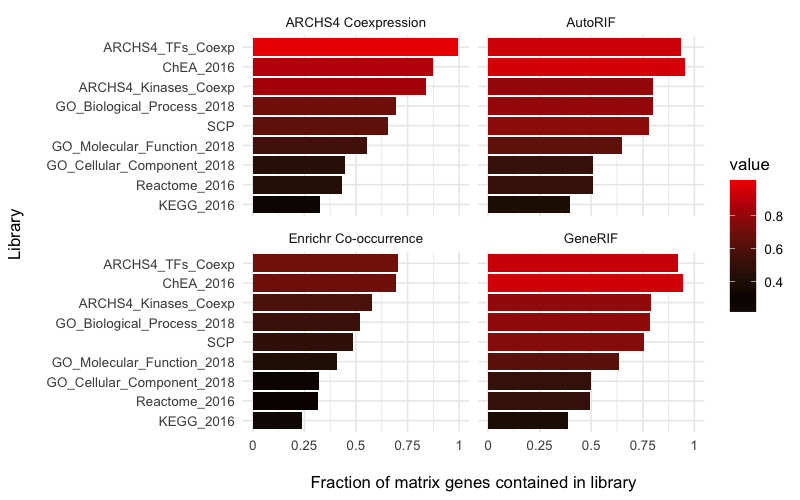

In [159]:
%%R -i library_represented_melt -h 500 -w 800 -r 110
ggplot(library_represented_melt, aes(x=reorder(index, value), y=value, fill=value)) +
geom_bar(stat='identity') +
facet_wrap(~variable) +
coord_flip() +
scale_fill_gradient2(mid='black', high='red2', midpoint=0.3) + 
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
scale_y_continuous(lim=c(0,1), breaks=ticks, labels=ticks) + 
# ggtitle('Fraction of similarity matrix genes contained in library') +
ylab('\nFraction of matrix genes contained in library') +
xlab('Library\n') +
theme_minimal() +
theme(plot.title = element_text(hjust = 0.5))

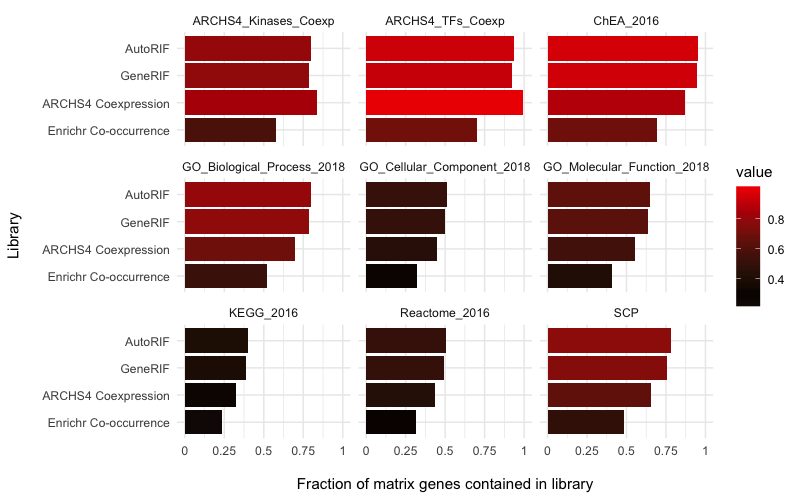

In [160]:
%%R -i library_represented_melt -h 500 -w 800 -r 100
ggplot(library_represented_melt, aes(x=reorder(variable, value), y=value, fill=value)) +
geom_bar(stat='identity') +
facet_wrap(~index) +
coord_flip() +
scale_fill_gradient2(mid='black', high='red2', midpoint=0.3) + 
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
scale_y_continuous(lim=c(0,1), breaks=ticks, labels=ticks) + 
# ggtitle('Fraction of similarity matrix genes contained in library') +
ylab('\nFraction of matrix genes contained in library') +
xlab('Library\n') +
theme_minimal() +
theme(plot.title = element_text(hjust = 0.5))

## 5. Lots of Venn diagrams

/Users/denis/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



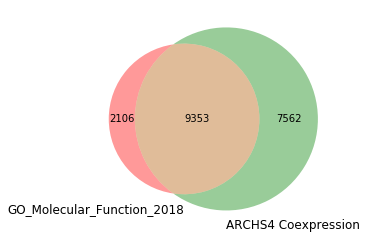

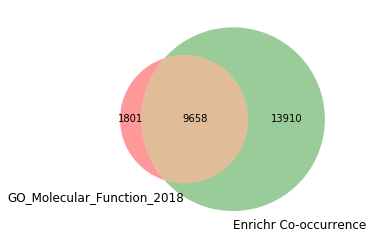

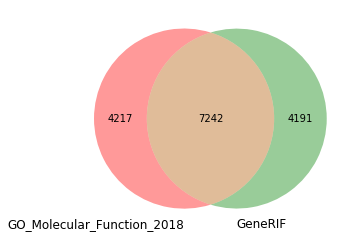

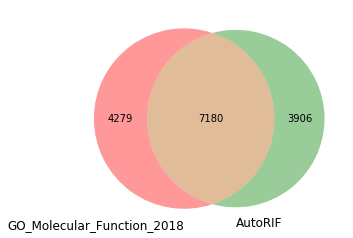

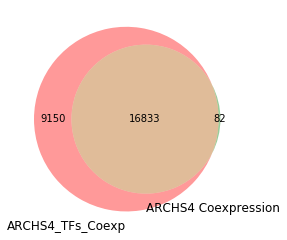

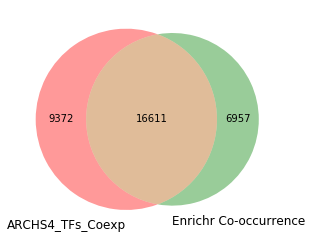

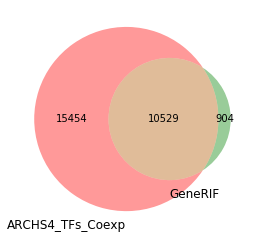

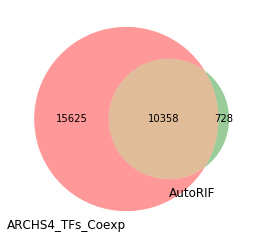

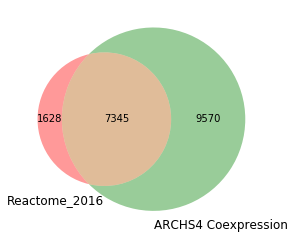

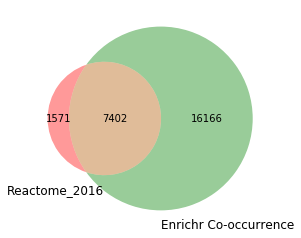

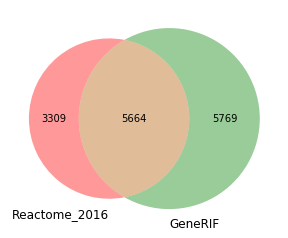

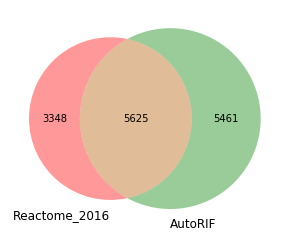

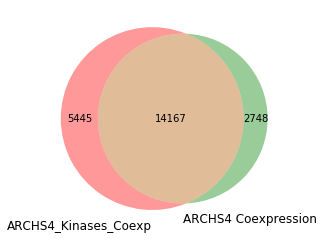

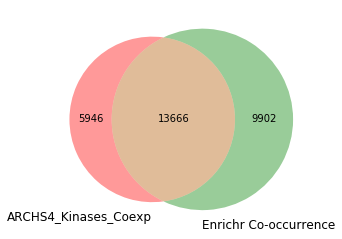

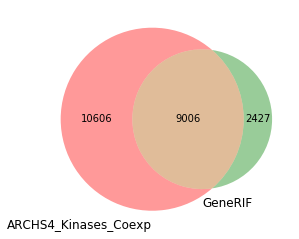

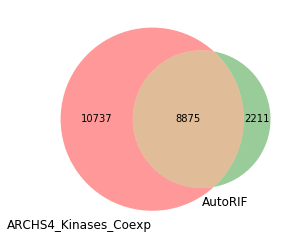

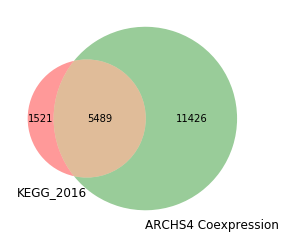

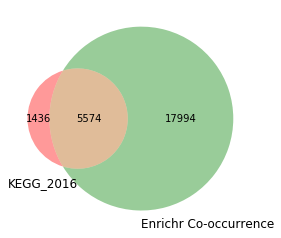

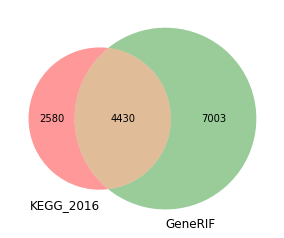

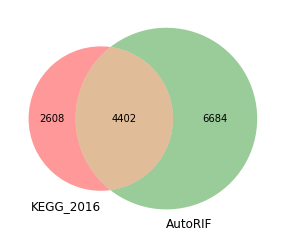

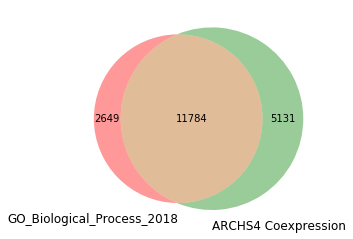

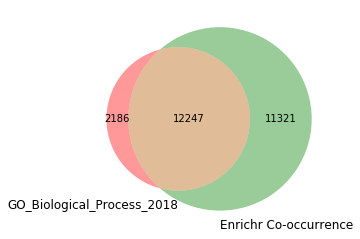

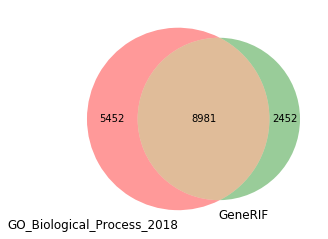

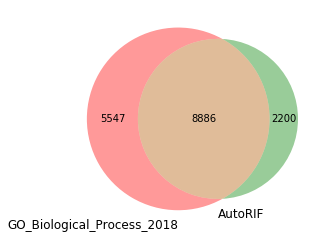

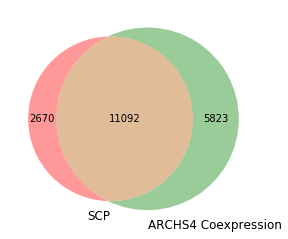

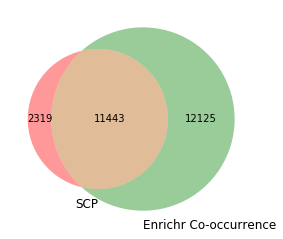

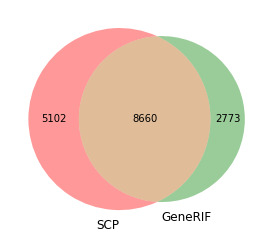

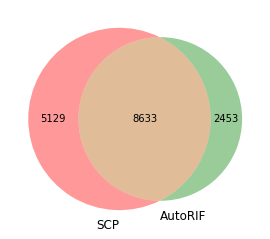

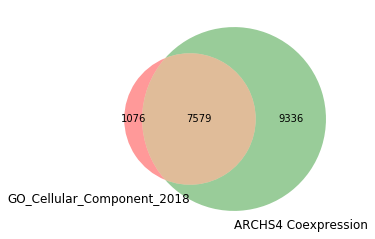

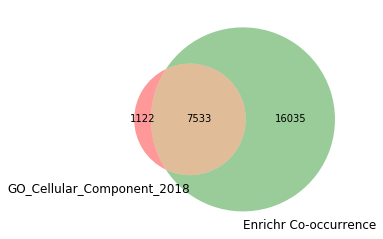

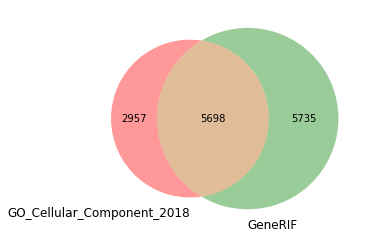

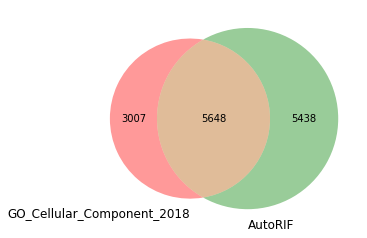

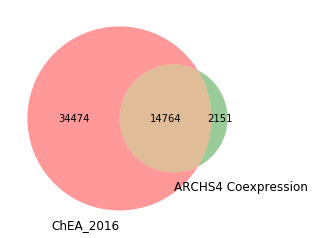

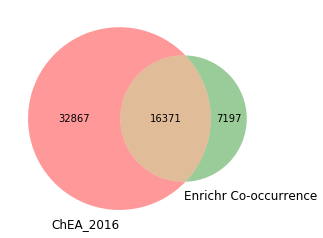

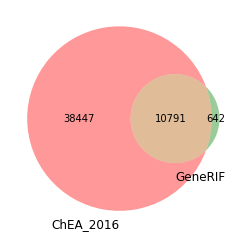

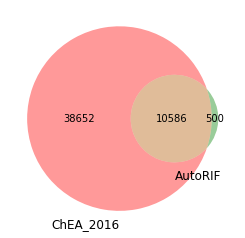

In [178]:
from matplotlib_venn import venn2
for library_name, library_geneset in libraries_merged.items():
#     display(Markdown('## '+library_name))
    for matrix_name, matrix_geneset in matrix_genes.items():
        plt.figure();
        venn2([library_geneset, matrix_geneset], set_labels=(library_name, matrix_name.replace('correlation', 'ARCHS4 Coexpression').replace('generif_overlap_zscore', 'GeneRIF').replace('autorif_overlap_zscore', 'AutoRIF').replace('zscore', 'Enrichr Co-occurrence')));
#         plt.close();